# LSTM 모델 테스트 - 산업용
---

In [85]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import Sequential
from keras.layers import LSTM, Conv1D, Dense, Dropout, GRU, TimeDistributed
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## [1] 데이터 로딩
---

In [86]:
data = pd.read_csv("./data/data_use.csv", index_col=0)
data_pred = pd.read_csv("./data/data_future.csv", index_col=0)
target = pd.read_csv("./data/target.csv", index_col=0)

In [87]:
data.head()

,POWER_GAS,ELEC_IND_SUM,OIL_PRICE,QVA,TCL_LT,TEMP_EF,ELEC_SERVICE
DATE,,,,,,,
1996-01-01,8408979,9236808,27.86,36550.300000,-0.189311,3.744768,3616542
1996-02-01,7593086,8465308,29.04,36751.000000,-0.226982,3.732234,3551611
1996-03-01,8306941,9677322,27.99,36951.700000,-0.045631,3.621268,3333225
1996-04-01,8299351,9650845,28.74,37152.400000,0.029456,3.460496,3430624
1996-05-01,8156027,9658045,29.18,37365.733333,0.242892,3.305460,3333483


In [88]:
data_pred.head()

,POWER_GAS,ELEC_IND_SUM,OIL_PRICE,QVA,TCL_LT,TEMP_EF,ELEC_SERVICE
DATE,,,,,,,
2021-01-01,21004815,24009895,106.270957,122715.511387,-0.819359,3.720112,1.546123e+07
2021-02-01,19006411,22411095,106.452033,123791.588066,-0.488770,3.663880,1.485668e+07
2021-03-01,17216940,23047185,106.615613,123126.447539,0.108879,3.557796,1.291000e+07
2021-04-01,15290843,22640767,106.796638,123534.791822,0.929050,3.418933,1.228525e+07
2021-05-01,15763108,22310541,106.971887,123756.051487,1.691170,3.297840,1.092951e+07


In [89]:
target.head()

,CIVIL,IND
DATE,,
1996-01-01,605519,83809
1996-02-01,566323,70427
1996-03-01,477514,62652
1996-04-01,337797,47050
1996-05-01,184522,30709


## [2] 데이터 전처리
---

### [2-1] 데이터 정규화

In [90]:
# 스케일러 생성
scaler = StandardScaler()

# minmax 스케일 적용
scaler.fit(data)
data_scaled_raw = scaler.transform(data)

In [91]:
# 스케일한 데이터 컬럼명 생성
data_cols = list(data.columns)

# 스케일한 데이터 형식 바꾸고 컬럼명 변경
data_scaled = pd.DataFrame(data_scaled_raw, columns=data_cols)
data_scaled.head()

,POWER_GAS,ELEC_IND_SUM,OIL_PRICE,QVA,TCL_LT,TEMP_EF,ELEC_SERVICE
0,0.134089,0.049688,0.000000,0.009127,0.211867,0.897574,0.024189
1,0.088435,0.002813,0.006917,0.011378,0.202764,0.879284,0.018796
2,0.128379,0.076453,0.000762,0.013628,0.246586,0.717359,0.000659
3,0.127954,0.074844,0.005159,0.015879,0.264731,0.482756,0.008748
4,0.119935,0.075281,0.007738,0.018271,0.316306,0.256523,0.000681


In [92]:
# target data 분할
target_ind = pd.DataFrame(target["IND"])
target_civil = pd.DataFrame(target["CIVIL"])

# 따로 정규화 작업
target_scaler = MinMaxScaler()
target_scaler.fit(target_ind)

target_scaled_ind = pd.DataFrame(target_scaler.transform(target_ind))

### [2-2] 데이터 분할

In [93]:
# input data 분할
ind_cols = ["TEMP_EF", "POWER_GAS", "ELEC_IND_SUM", "OIL_PRICE", "QVA"]
civil_cols = ["TCL_LT", "TEMP_EF", "ELEC_SERVICE" ]

data_ind = data_scaled.loc[:, ind_cols]
data_ind["TEMP_EF"] = data_ind["TEMP_EF"] * 1.5
# data_ind["POWER_GAS"] = data_ind["POWER_GAS"] * 1.5
# data_ind["OIL_PRICE"] = data_ind["OIL_PRICE"] * 1

data_civil = data_scaled.loc[:, civil_cols]

In [94]:
# train test 분할
# ind set
X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
    data_ind, target_scaled_ind, shuffle=False, test_size=0.3, random_state=42
)

# civil set
X_train_civil, X_test_civil, y_train_civil, y_test_civil = train_test_split(
    data_civil, target_civil, shuffle=False, test_size=0.3, random_state=42
)

In [95]:
# shape 출력
X_train_ind.shape, X_test_ind.shape

((210, 5), (90, 5))

In [96]:
y_train_ind.shape, y_test_ind.shape

((210, 1), (90, 1))

### [2-3] 시퀀스 데이터셋 구성

In [97]:
def windowed_dataset(X, y, window_size, batch_size, shuffle):
    # X 값 window dataset 구성
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    X_ds = X_ds.window(window_size, shift=1, stride=1, drop_remainder=True)
    X_ds = X_ds.flat_map(lambda x: x.batch(window_size))
    # y 값 추가
    y_ds = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((X_ds, y_ds))
    if shuffle:
        ds = ds.shuffle(80)
        
    return ds.batch(batch_size).prefetch(1)

In [98]:
# 모델에 사용될 변수 저장
WINDOW_SIZE = 6
BATCH_SIZE = 32
INPUT_SHAPE_IND = (WINDOW_SIZE, X_train_ind.shape[1])
INPUT_SHAPE_CIVIL = (WINDOW_SIZE, X_train_civil.shape[1])

# ind dataset 생성
train_ds_ind = windowed_dataset(X_train_ind, y_train_ind, WINDOW_SIZE, BATCH_SIZE, True)
test_ds_ind = windowed_dataset(X_test_ind, y_test_ind, WINDOW_SIZE, BATCH_SIZE, False)

# civil dataset 생성
train_ds_civil = windowed_dataset(X_train_civil, y_train_civil, WINDOW_SIZE, BATCH_SIZE, True)
test_ds_civil = windowed_dataset(X_test_civil, y_test_civil, WINDOW_SIZE, BATCH_SIZE, False)

## [3] 모델 생성
---

### [3-1] IND 모델

In [99]:
# 랜덤 시드 고정
tf.random.set_seed(42)

In [100]:
# LSTM 모델 생성
def LSTM_model(filters, units, input_shape):
    model = Sequential(
        [
            Conv1D(
                filters=filters, kernel_size=3, activation="relu", input_shape=input_shape
            ),
            GRU(units, return_sequences=True),
            GRU(units*2, return_sequences=True),
            GRU(units),
            Dense(1),
        ]
    )

    # loss: sequence에서 좋은 성능을 보여주는 Huber 사용
    loss = Huber()
    # optimizer: Adam 사용
    optimizer = Adam(0.0005)

    model.compile(optimizer=optimizer, loss=loss, metrics="mse")
    
    return model

In [101]:
model_ind = LSTM_model(32, 64, INPUT_SHAPE_IND)
model_ind.fit(train_ds_ind, epochs=100, verbose=False)

In [102]:
pred = model_ind.predict(test_ds_ind)

# pred = ind_scaler.inverse_transform(pred)

3/3 [==============================] - 0s 9ms/step


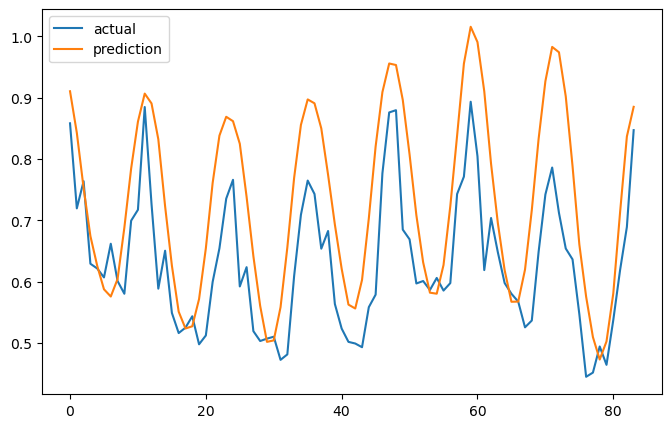

In [103]:
plt.figure(figsize=(8, 5))
plt.plot(np.asarray(y_test_ind)[WINDOW_SIZE:], label="actual")
plt.plot(pred, label="prediction")
plt.legend()
plt.show()

## [4] 예측 모델
---

In [104]:
# 예측 데이터 불러오기
data_pred_ind = data_pred.loc[:, ind_cols]
data_pred_front = data.loc[:, ind_cols].iloc[294:,:]

data_pred_ind = pd.concat([data_pred_front, data_pred_ind], axis=0)

In [105]:
def pred_dataset(X, window_size, batch_size):
    # X 값 window dataset 구성
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    X_ds = X_ds.window(window_size, shift=1, stride=1, drop_remainder=True)
    X_ds = X_ds.flat_map(lambda x: x.batch(window_size))

    return X_ds.batch(batch_size).prefetch(1)

In [106]:
# 예측 데이터셋
pred_ds = pred_dataset(data_pred_ind, WINDOW_SIZE, BATCH_SIZE)

pred = model_ind.predict(pred_ds)

pred = list(target_scaler.inverse_transform(pred))

6/6 [==============================] - 1s 6ms/step


In [111]:
pred

[array([4439092.], dtype=float32),
 array([4537031.], dtype=float32),
 array([4533323.], dtype=float32),
 array([4286603.5], dtype=float32),
 array([4200491.5], dtype=float32),
 array([4231050.5], dtype=float32),
 array([4339597.5], dtype=float32),
 array([4491761.], dtype=float32),
 array([4506493.5], dtype=float32),
 array([4370734.], dtype=float32),
 array([4314285.5], dtype=float32),
 array([4346570.5], dtype=float32),
 array([4467626.5], dtype=float32),
 array([4572653.], dtype=float32),
 array([4555938.5], dtype=float32),
 array([4587745.5], dtype=float32),
 array([4534627.], dtype=float32),
 array([4562235.5], dtype=float32),
 array([4529341.5], dtype=float32),
 array([4548418.], dtype=float32),
 array([4527765.5], dtype=float32),
 array([4370734.], dtype=float32),
 array([4314285.5], dtype=float32),
 array([4346570.5], dtype=float32),
 array([4455417.], dtype=float32),
 array([4487720.], dtype=float32),
 array([4385443.5], dtype=float32),
 array([4498595.5], dtype=float32),
 ar

In [110]:
target_ind

,IND
DATE,
1996-01-01,83809
1996-02-01,70427
1996-03-01,62652
1996-04-01,47050
1996-05-01,30709
...,...
2020-08-01,457970
2020-09-01,525619
2020-10-01,600890
